# SLEAP Distance Calculation

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
import git
import sys


In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


In [3]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [4]:
git_root

'/nancy/projects/reward_competition_extention'

In [5]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [6]:
import utilities.helper
import sleap.process_pose

In [7]:
# sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

## Inputs & Data

Explanation of each input and where it comes from.

In [8]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
THORAX_INDEX = 1
# TONE_TIMESTAMP_DF = pd.read_csv("./proc/rce_tone_timestamp.csv", index_col=0)
# VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.read_excel("../../proc/video_to_frame_and_subject.xlsx")
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.read_pickle(os.path.join(git_root, "notebooks/export/proc/rce_pilot_2_full_lfp_traces_and_video_frames.pkl"))
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].apply(lambda x: x.strip(".videoTimeStamps.cameraHWSync"))

# SLEAP_DIR = os.path.join(git_root, "proc/sleap") 
SLEAP_DIR = "/scratch/back_up/reward_competition_extention/final_proc/id_corrected"

OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
MED_PC_WIDTH = 29.5
MED_PC_HEIGHT = 24
FRAME_RATE = 22
WINDOW_SIZE = 25
DISTANCE_THRESHOLD = 2

In [9]:
START_STOP_FRAME_DF = pd.read_excel("./rce_per_subject_start_stop_video_frame.xlsx").dropna(subset=["file_path"])

In [10]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,cohort,session_dir,tone_frames,port_entry_frames,video_name,session_path,recording,subject,all_subjects,first_timestamp,raw_timestamps,video_timestamps,tone_timestamps,port_entry_timestamps,lfp_timestamps,mpfc_lfp_trace,vhpc_lfp_trace,bla_lfp_trace,lh_lfp_trace,md_lfp_trace
0,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,"[1.1, 1.2]",3478533,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-2, 1384, 1500, 2770, 4156, 5542, 5542, 6927,...","[[1030879, 1230878], [3430878, 3630878], [5730...","[[102478, 104881], [110481, 147879], [193083, ...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.07365118, 0.11047677, 0.18994251, 0.2364590...","[-0.26256362, -0.19967411, -0.015722372, 0.150...","[0.28542638, 0.8104071, 1.2419446, 1.0261759, ...","[0.0040029064, -0.11808574, -0.052037787, 0.17...","[0.103898674, -0.011922799, 0.020439083, 0.136..."
1,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,"[1.1, 1.2]",3478533,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-2, 1384, 1500, 2770, 4156, 5542, 5542, 6927,...","[[1030879, 1230878], [3430878, 3630878], [5730...","[[102478, 104881], [110481, 147879], [193083, ...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.9489666, 1.1787612, 1.587285, 1.6766496, 1....","[-0.59670866, -0.5804559, -0.500353, -0.304158...","[0.57716405, 1.2267566, 1.8559785, 1.9170899, ...","[1.0252244, 1.567814, 1.8645895, 1.6457549, 1....","[0.8103085, 0.9092951, 0.8448387, 0.6675837, 0..."
2,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,"[1.1, 1.4]",835680,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-2, 1384, 2770, 2770, 4155, 5541, 6927, 6927,...","[[1099250, 1299250], [3499256, 3699252], [5799...","[[788852, 836852], [838652, 840050], [840652, ...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[-0.3153952, -0.28119573, -0.2697959, -0.33819...","[0.9725201, 1.5246606, 2.241502, 2.4265945, 2....","[0.18319474, 0.4846334, 0.7660871, 0.85435367,...","[0.33724487, 0.4972933, 0.52396804, 0.39059433...","[0.0032272236, -0.066158086, -0.07422615, 0.05..."
3,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.4,"[1.1, 1.4]",835680,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-2, 1384, 2770, 2770, 4155, 5541, 6927, 6927,...","[[1099250, 1299250], [3499256, 3699252], [5799...","[[788852, 836852], [838652, 840050], [840652, ...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.08225485, 0.06580388, -0.13160776, -0.78964...","[-0.75467384, -1.4102968, -2.273455, -2.297038...","[-0.14317, -0.52495664, -1.2980746, -1.0435501...","[-0.8462542, -1.1688362, -1.3489795, -1.064101...","[-0.4082438, -0.6508234, -0.85198706, -0.83423..."
4,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.1,"[

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

In [11]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce_pilot_2"

In [12]:
FULL_LFP_TRACES_PKL = "{}_full_lfp_traces_and_sleap_poses.pkl".format(OUTPUT_PREFIX)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

# Reading in the h5 files between recordings

In [13]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,cohort,session_dir,tone_frames,port_entry_frames,video_name,session_path,recording,subject,all_subjects,first_timestamp,raw_timestamps,video_timestamps,tone_timestamps,port_entry_timestamps,lfp_timestamps,mpfc_lfp_trace,vhpc_lfp_trace,bla_lfp_trace,lh_lfp_trace,md_lfp_trace
0,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,"[1.1, 1.2]",3478533,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-2, 1384, 1500, 2770, 4156, 5542, 5542, 6927,...","[[1030879, 1230878], [3430878, 3630878], [5730...","[[102478, 104881], [110481, 147879], [193083, ...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.07365118, 0.11047677, 0.18994251, 0.2364590...","[-0.26256362, -0.19967411, -0.015722372, 0.150...","[0.28542638, 0.8104071, 1.2419446, 1.0261759, ...","[0.0040029064, -0.11808574, -0.052037787, 0.17...","[0.103898674, -0.011922799, 0.020439083, 0.136..."
1,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,"[1.1, 1.2]",3478533,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-2, 1384, 1500, 2770, 4156, 5542, 5542, 6927,...","[[1030879, 1230878], [3430878, 3630878], [5730...","[[102478, 104881], [110481, 147879], [193083, ...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.9489666, 1.1787612, 1.587285, 1.6766496, 1....","[-0.59670866, -0.5804559, -0.500353, -0.304158...","[0.57716405, 1.2267566, 1.8559785, 1.9170899, ...","[1.0252244, 1.567814, 1.8645895, 1.6457549, 1....","[0.8103085, 0.9092951, 0.8448387, 0.6675837, 0..."
2,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,"[1.1, 1.4]",835680,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-2, 1384, 2770, 2770, 4155, 5541, 6927, 6927,...","[[1099250, 1299250], [3499256, 3699252], [5799...","[[788852, 836852], [838652, 840050], [840652, ...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[-0.3153952, -0.28119573, -0.2697959, -0.33819...","[0.9725201, 1.5246606, 2.241502, 2.4265945, 2....","[0.18319474, 0.4846334, 0.7660871, 0.85435367,...","[0.33724487, 0.4972933, 0.52396804, 0.39059433...","[0.0032272236, -0.066158086, -0.07422615, 0.05..."
3,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.4,"[1.1, 1.4]",835680,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-2, 1384, 2770, 2770, 4155, 5541, 6927, 6927,...","[[1099250, 1299250], [3499256, 3699252], [5799...","[[788852, 836852], [838652, 840050], [840652, ...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.08225485, 0.06580388, -0.13160776, -0.78964...","[-0.75467384, -1.4102968, -2.273455, -2.297038...","[-0.14317, -0.52495664, -1.2980746, -1.0435501...","[-0.8462542, -1.1688362, -1.3489795, -1.064101...","[-0.4082438, -0.6508234, -0.85198706, -0.83423..."
4,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.1,"[

- Getting the names of each subject

In [14]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].iloc[0]

'20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1'

In [15]:
# VIDEO_TO_FRAME_AND_SUBJECT_DF["video_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].apply(lambda x: os.path.join(SLEAP_DIR, "*", x + "*.h5"))
VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_glob"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].apply(lambda x: glob.glob(os.path.join(SLEAP_DIR, "*", x + "*2_subj*.h5")))
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF[VIDEO_TO_FRAME_AND_SUBJECT_DF['sleap_glob'].apply(lambda x: len(x) == 1)]
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.reset_index(drop=True)


VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_glob"].apply(lambda x: x[0])

In [16]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,cohort,session_dir,tone_frames,port_entry_frames,video_name,session_path,recording,subject,all_subjects,first_timestamp,...,tone_timestamps,port_entry_timestamps,lfp_timestamps,mpfc_lfp_trace,vhpc_lfp_trace,bla_lfp_trace,lh_lfp_trace,md_lfp_trace,sleap_glob,sleap_path
0,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,"[1.1, 1.2]",3478533,...,"[[1030879, 1230878], [3430878, 3630878], [5730...","[[102478, 104881], [110481, 147879], [193083, ...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.07365118, 0.11047677, 0.18994251, 0.2364590...","[-0.26256362, -0.19967411, -0.015722372, 0.150...","[0.28542638, 0.8104071, 1.2419446, 1.0261759, ...","[0.0040029064, -0.11808574, -0.052037787, 0.17...","[0.103898674, -0.011922799, 0.020439083, 0.136...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...
1,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,"[1.1, 1.2]",3478533,...,"[[1030879, 1230878], [3430878, 3630878], [5730...","[[102478, 104881], [110481, 147879], [193083, ...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.9489666, 1.1787612, 1.587285, 1.6766496, 1....","[-0.59670866, -0.5804559, -0.500353, -0.304158...","[0.57716405, 1.2267566, 1.8559785, 1.9170899, ...","[1.0252244, 1.567814, 1.8645895, 1.6457549, 1....","[0.8103085, 0.9092951, 0.8448387, 0.6675837, 0...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...
2,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,"[1.1, 1.4]",835680,...,"[[1099250, 1299250], [3499256, 3699252], [5799...","[[788852, 836852], [838652, 840050], [840652, ...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[-0.3153952, -0.28119573, -0.2697959, -0.33819...","[0.9725201, 1.5246606, 2.241502, 2.4265945, 2....","[0.18319474, 0.4846334, 0.7660871, 0.85435367,...","[0.33724487, 0.4972933, 0.52396804, 0.39059433...","[0.0032272236, -0.066158086, -0.07422615, 0.05...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...
3,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.4,"[1.1, 1.4]",835680,...,"[[1099250, 1299250], [3499256, 3699252], [5799...","[[788852, 836852], [838652, 840050], [840652, ...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[0.08225485, 0.06580388, -0.13160776, -0.78964...","[-0.75467384, -1.4102968, -2.273455, -2.297038...","[-0.14317, -0.52495664, -1.2980746, -1.0435501...","[-0.8462542, -1.1688362, -1.3489795, -1.064101...","[-0.4082438, -0.6508234, -0.85198706, -0.83423...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...
4,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.1,"[1.1, 1

In [17]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: sleap.process_pose.extract_sleap_data(x))


In [18]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["locations"])

In [19]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["track_names"])

In [20]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"]

0    [1.1, 1.2, track_862, track_863, track_1067, t...
1    [1.1, 1.2, track_862, track_863, track_1067, t...
2    [1.1, 1.4, track_867, track_868, track_869, tr...
3    [1.1, 1.4, track_867, track_868, track_869, tr...
4    [1.1, 1.2, track_16, track_18, track_40, track...
5    [1.1, 1.2, track_16, track_18, track_40, track...
6    [1.2, 1.4, track_711, track_712, track_713, tr...
Name: track_names, dtype: object

In [21]:
# Getting the coordinates of all the body parts for all the animals for the entire recording
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: sleap.process_pose.get_sleap_tracks_from_h5(x))
# Getting the name of the tracks which correspond to the animal id
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: sleap.process_pose.get_sleap_track_names_from_h5(x))

In [22]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"].iloc[0].shape

(79051, 6, 2, 10)

In [23]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"].iloc[0]

['1.1',
 '1.2',
 'track_862',
 'track_863',
 'track_1067',
 'track_1068',
 'track_1148',
 'track_1149',
 'track_1153',
 'track_1154']

In [24]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject"]

0    1.1
1    1.2
2    1.1
3    1.4
4    1.1
5    1.2
6    1.4
Name: subject, dtype: object

In [25]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"]

0    [1.1, 1.2, track_862, track_863, track_1067, t...
1    [1.1, 1.2, track_862, track_863, track_1067, t...
2    [1.1, 1.4, track_867, track_868, track_869, tr...
3    [1.1, 1.4, track_867, track_868, track_869, tr...
4    [1.1, 1.2, track_16, track_18, track_40, track...
5    [1.1, 1.2, track_16, track_18, track_40, track...
6    [1.2, 1.4, track_711, track_712, track_713, tr...
Name: track_names, dtype: object

In [26]:
# Getting the indexes of each subject from the track list
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["track_names"].index(k) for k in x["all_subjects"] if k in x["track_names"]}, axis=1)

In [27]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"]

0    {'1.1': 0, '1.2': 1}
1    {'1.1': 0, '1.2': 1}
2    {'1.1': 0, '1.4': 1}
3    {'1.1': 0, '1.4': 1}
4    {'1.1': 0, '1.2': 1}
5    {'1.1': 0, '1.2': 1}
6    {'1.2': 0, '1.4': 1}
Name: subject_to_index, dtype: object

In [28]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k:v for k, v in x["subject_to_index"].items()}, axis=1)

In [29]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

0    {'1.1': 0, '1.2': 1}
1    {'1.1': 0, '1.2': 1}
2    {'1.1': 0, '1.4': 1}
3    {'1.1': 0, '1.4': 1}
4    {'1.1': 0, '1.2': 1}
5    {'1.1': 0, '1.2': 1}
6    {'1.2': 0, '1.4': 1}
Name: subject_to_tracks, dtype: object

In [30]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["locations"][:,:,:,v] for k, v in x["subject_to_index"].items()}, axis=1)

In [31]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

0    {'1.1': [[[416.6953125  348.36172485], [432.06...
1    {'1.1': [[[416.6953125  348.36172485], [432.06...
2    {'1.1': [[[340.27038574 388.14276123], [324.34...
3    {'1.1': [[[340.27038574 388.14276123], [324.34...
4    {'1.1': [[[303.96658325 368.13119507], [299.83...
5    {'1.1': [[[303.96658325 368.13119507], [299.83...
6    {'1.2': [[[359.87313843 259.55477905], [336.01...
Name: subject_to_tracks, dtype: object

In [32]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,cohort,session_dir,tone_frames,port_entry_frames,video_name,session_path,recording,subject,all_subjects,first_timestamp,...,bla_lfp_trace,lh_lfp_trace,md_lfp_trace,sleap_glob,sleap_path,all_sleap_data,locations,track_names,subject_to_index,subject_to_tracks
0,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,"[1.1, 1.2]",3478533,...,"[0.28542638, 0.8104071, 1.2419446, 1.0261759, ...","[0.0040029064, -0.11808574, -0.052037787, 0.17...","[0.103898674, -0.011922799, 0.020439083, 0.136...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[416.6953125 288.3494873 ...,[[[[416.6953125 288.3494873 nan ...,"[1.1, 1.2, track_862, track_863, track_1067, t...","{'1.1': 0, '1.2': 1}","{'1.1': [[[416.6953125 348.36172485], [432.06..."
1,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,"[1.1, 1.2]",3478533,...,"[0.57716405, 1.2267566, 1.8559785, 1.9170899, ...","[1.0252244, 1.567814, 1.8645895, 1.6457549, 1....","[0.8103085, 0.9092951, 0.8448387, 0.6675837, 0...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[416.6953125 288.3494873 ...,[[[[416.6953125 288.3494873 nan ...,"[1.1, 1.2, track_862, track_863, track_1067, t...","{'1.1': 0, '1.2': 1}","{'1.1': [[[416.6953125 348.36172485], [432.06..."
2,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,"[1.1, 1.4]",835680,...,"[0.18319474, 0.4846334, 0.7660871, 0.85435367,...","[0.33724487, 0.4972933, 0.52396804, 0.39059433...","[0.0032272236, -0.066158086, -0.07422615, 0.05...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[340.27038574 227.90209961 ...,[[[[340.27038574 227.90209961 nan ...,"[1.1, 1.4, track_867, track_868, track_869, tr...","{'1.1': 0, '1.4': 1}","{'1.1': [[[340.27038574 388.14276123], [324.34..."
3,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.4,"[1.1, 1.4]",835680,...,"[-0.14317, -0.52495664, -1.2980746, -1.0435501...","[-0.8462542, -1.1688362, -1.3489795, -1.064101...","[-0.4082438, -0.6508234, -0.85198706, -0.83423...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[340.27038574 227.90209961 ...,[[[[340.27038574 227.90209961 nan ...,"[1.1, 1.4, track_867, track_868, track_869, tr...","{'1.1': 0, '1.4': 1}","{'1.1': [[[340.27038574 388.14276123], [324.34..."
4,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.1,"[1.1, 1.2]",2502881,...,"[-0.1226345, -0.42922074, -0.6099453, -0.56153...","[-0.1610439, -0.28040585, -0.1496761, 0.113678...","[-0.28975692, -0.2704398, 0.02253665, 0.333220...",[/scratch/back_up/reward_competition

## Getting the coordinates of the corners

In [33]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].iloc[0]

'/scratch/back_up/reward_competition_extention/final_proc/id_corrected/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1.fixed.2_subj.round_1.id_corrected.h5'

In [34]:
# Each corner file is the in the same folder and has the same basename of the pose tracking file 
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: x.replace("id_corrected.h5", "corner.h5").replace(".fixed", "").replace(".round_1", "").replace(".1_subj", "").replace(".2_subj", ""))


In [35]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].iloc[0]

'/scratch/back_up/reward_competition_extention/final_proc/id_corrected/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1.corner.h5'

In [36]:
# Getting the indexes of each corner location
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: sleap.process_pose.get_node_names_from_sleap(x))

In [37]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"]

0    [box_top_left, box_bottom_left, box_bottom_rig...
1    [box_top_left, box_bottom_left, box_bottom_rig...
2    [box_top_left, box_bottom_right, box_bottom_le...
3    [box_top_left, box_bottom_right, box_bottom_le...
4    [reward_port, box_top_left, box_bottom_right, ...
5    [reward_port, box_top_left, box_bottom_right, ...
6    [box_bottom_right, reward_port, box_top_right,...
Name: corner_parts, dtype: object

In [38]:
# Getting the coordinates of all the corners
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: sleap.process_pose.get_sleap_tracks_from_h5(x))

In [39]:
# Parsing out each corner and creating a dictionary of name to coordinates
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {part: x["corner_to_coordinate"][:,index,:,:] for index, part in enumerate(x["corner_parts"])}, axis=1)

In [40]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"]

0    {'box_top_left': [[[213.33513266], [119.825808...
1    {'box_top_left': [[[213.33513266], [119.825808...
2    {'box_top_left': [[[nan], [nan]], [[nan], [nan...
3    {'box_top_left': [[[nan], [nan]], [[nan], [nan...
4    {'reward_port': [[[nan], [nan]], [[nan], [nan]...
5    {'reward_port': [[[nan], [nan]], [[nan], [nan]...
6    {'box_bottom_right': [[[429.48488242], [381.87...
Name: corner_to_coordinate, dtype: object

In [41]:
# Filtering out all the Nans because there's only one labeled frame
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: v[~np.isnan(v)][:2] for k, v in x["corner_to_coordinate"].items()}, axis=1)

In [42]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].iloc[0]

{'box_top_left': array([213.33513266, 119.82580872]),
 'box_bottom_left': array([217.7043673 , 381.96901937]),
 'box_bottom_right': array([431.87997309, 384.27971548]),
 'reward_port': array([326.10716359, 401.40811349]),
 'box_top_right': array([424.05287064, 116.50390509])}

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [43]:
# Using the x-coordinates for the width
VIDEO_TO_FRAME_AND_SUBJECT_DF["bottom_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][0] - x["box_bottom_left"][0])
VIDEO_TO_FRAME_AND_SUBJECT_DF["top_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_top_right"][0] - x["box_top_left"][0])


In [44]:
# Using the y-coordinates for the height
VIDEO_TO_FRAME_AND_SUBJECT_DF["right_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][1] - x["box_top_right"][1])
VIDEO_TO_FRAME_AND_SUBJECT_DF["left_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_left"][1] - x["box_top_left"][1])


In [45]:
# averaging the width and height by adding both sides and then getting the mean
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [46]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"] = MED_PC_WIDTH / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"]
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"] = MED_PC_HEIGHT / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"]

In [47]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"]

0    0.090580
1    0.090580
2    0.092440
3    0.092440
4    0.090034
5    0.090034
6    0.091223
Name: height_ratio, dtype: float64

In [48]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"]

0    0.138858
1    0.138858
2    0.137652
3    0.137652
4    0.137434
5    0.137434
6    0.138960
Name: width_ratio, dtype: float64

## Converting Pixels to cm

- Converting the X-dimension

In [49]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

0    {'1.1': [[[416.6953125  348.36172485], [432.06...
1    {'1.1': [[[416.6953125  348.36172485], [432.06...
2    {'1.1': [[[340.27038574 388.14276123], [324.34...
3    {'1.1': [[[340.27038574 388.14276123], [324.34...
4    {'1.1': [[[303.96658325 368.13119507], [299.83...
5    {'1.1': [[[303.96658325 368.13119507], [299.83...
6    {'1.2': [[[359.87313843 259.55477905], [336.01...
Name: subject_to_tracks, dtype: object

In [50]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,cohort,session_dir,tone_frames,port_entry_frames,video_name,session_path,recording,subject,all_subjects,first_timestamp,...,corner_parts,corner_to_coordinate,bottom_width,top_width,right_height,left_height,average_height,average_width,width_ratio,height_ratio
0,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,"[1.1, 1.2]",3478533,...,"[box_top_left, box_bottom_left, box_bottom_rig...","{'box_top_left': [213.33513266009683, 119.8258...",214.175606,210.717738,267.775810,262.143211,264.959511,212.446672,0.138858,0.090580
1,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,"[1.1, 1.2]",3478533,...,"[box_top_left, box_bottom_left, box_bottom_rig...","{'box_top_left': [213.33513266009683, 119.8258...",214.175606,210.717738,267.775810,262.143211,264.959511,212.446672,0.138858,0.090580
2,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,"[1.1, 1.4]",835680,...,"[box_top_left, box_bottom_right, box_bottom_le...","{'box_top_left': [210.30936448661504, 125.0467...",215.705835,212.910631,262.699068,256.558648,259.628858,214.308233,0.137652,0.092440
3,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.4,"[1.1, 1.4]",835680,...,"[box_top_left, box_bottom_right, box_bottom_le...","{'box_top_left': [210.30936448661504, 125.0467...",215.705835,212.910631,262.699068,256.558648,259.628858,214.308233,0.137652,0.092440
4,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.1,"[1.1, 1.2]",2502881,...,"[reward_port, box_top_left, box_bottom_right, ...","{'reward_port': [324.08885973592385, 405.86618...",214.237848,215.057661,265.010397,268.123016,266.566707,214.647754,0.137434,0.090034
5,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.2,"[1.1, 1.2]",2502881,...,"[reward_port, box_top_left, box_bottom_right, ...","{'reward_port': [324.08885973592385, 405.86618...",214.237848,215.057661,265.010397,268.123016,266.566707,214.647754,0.137434,0.090034
6,2,20230621_111240_standard_comp_to_omission_D5_s...,"[[477, 1286], [2484, 2683], [4880, 5079], [717...","[[223, 250], [252, 254], [257, 257], [258, 297...",20230621_111240_standard_comp_to_omission_D5_s...,/scratch/back_up/reward_competition_extention/...,20230621_111240_standard_comp_to_omission_D5_s...,1.4,"[1.2, 1.4]",3193044,...,"[box_bottom_right, reward_port, box_top_right,...","{'box_bottom_right': [429.48488241881296, 381....",211.488533,213.095513,261.626127,264.555774,263.090950,212.292023,0.138960,0.091223


In [51]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {key: sleap.process_pose.fill_missing(sleap.process_pose.rescale_dimension_in_array(value, dimension=0, ratio=x["width_ratio"])) for key, value in x["subject_to_tracks"].items()}, axis=1)

- Converting the Y-dimension

In [52]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {key: sleap.process_pose.rescale_dimension_in_array(value, dimension=1, ratio=x["height_ratio"]) for key, value in x["rescaled_locations"].items()}, axis=1)

In [53]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"]

0    {'box_top_left': [213.33513266009683, 119.8258...
1    {'box_top_left': [213.33513266009683, 119.8258...
2    {'box_top_left': [210.30936448661504, 125.0467...
3    {'box_top_left': [210.30936448661504, 125.0467...
4    {'reward_port': [324.08885973592385, 405.86618...
5    {'reward_port': [324.08885973592385, 405.86618...
6    {'box_bottom_right': [429.48488241881296, 381....
Name: corner_to_coordinate, dtype: object

In [54]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,cohort,session_dir,tone_frames,port_entry_frames,video_name,session_path,recording,subject,all_subjects,first_timestamp,...,corner_to_coordinate,bottom_width,top_width,right_height,left_height,average_height,average_width,width_ratio,height_ratio,rescaled_locations
0,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,"[1.1, 1.2]",3478533,...,"{'box_top_left': [213.33513266009683, 119.8258...",214.175606,210.717738,267.775810,262.143211,264.959511,212.446672,0.138858,0.090580,"{'1.1': [[[57.86163469 31.55456236], [59.99533..."
1,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,"[1.1, 1.2]",3478533,...,"{'box_top_left': [213.33513266009683, 119.8258...",214.175606,210.717738,267.775810,262.143211,264.959511,212.446672,0.138858,0.090580,"{'1.1': [[[57.86163469 31.55456236], [59.99533..."
2,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,"[1.1, 1.4]",835680,...,"{'box_top_left': [210.30936448661504, 125.0467...",215.705835,212.910631,262.699068,256.558648,259.628858,214.308233,0.137652,0.092440,"{'1.1': [[[46.8389676 35.87977984], [44.64656..."
3,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.4,"[1.1, 1.4]",835680,...,"{'box_top_left': [210.30936448661504, 125.0467...",215.705835,212.910631,262.699068,256.558648,259.628858,214.308233,0.137652,0.092440,"{'1.1': [[[46.8389676 35.87977984], [44.64656..."
4,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.1,"[1.1, 1.2]",2502881,...,"{'reward_port': [324.08885973592385, 405.86618...",214.237848,215.057661,265.010397,268.123016,266.566707,214.647754,0.137434,0.090034,"{'1.1': [[[41.77548574 33.14423169], [41.20698..."
5,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.2,"[1.1, 1.2]",2502881,...,"{'reward_port': [324.08885973592385, 405.86618...",214.237848,215.057661,265.010397,268.123016,266.566707,214.647754,0.137434,0.090034,"{'1.1': [[[41.77548574 33.14423169], [41.20698..."
6,2,20230621_111240_standard_comp_to_omission_D5_s...,"[[477, 1286], [2484, 2683], [4880, 5079], [717...","[[223, 250], [252, 254], [257, 257], [258, 297...",20230621_111240_standard_comp_to_omission_D5_s...,/scratch/back_up/reward_competition_extention/...,20230621_111240_standard_comp_to_omission_D5_s...,1.4,"[1.2, 1.4]",3193044,...,"{'box_bottom_right': [429.48488241881296, 381....",211.488533,213.095513,261.626127,264.555774,263.090950,212.292023,0.138960,0.091223,"{'1.2': [[[50.0078026 23.67741913], [46.69294..."


In [55]:
# Normalize dictionary column
normalized = pd.json_normalize(VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"])

In [56]:
normalized

,box_top_left,box_bottom_left,box_bottom_right,reward_port,box_top_right
0,"[213.33513266009683, 119.82580872252663]","[217.7043673012318, 381.969019365155]","[431.87997309078077, 384.27971548191636]","[326.10716358867114, 401.40811348731864]","[424.05287063805486, 116.50390509313942]"
1,"[213.33513266009683, 119.82580872252663]","[217.7043673012318, 381.969019365155]","[431.87997309078077, 384.27971548191636]","[326.10716358867114, 401.40811348731864]","[424.05287063805486, 116.50390509313942]"
2,"[210.30936448661504, 125.04673201622876]","[216.44422093087914, 381.6053799064849]","[432.1500559910414, 382.6164985908858]","[323.9681885492672, 403.40074541633544]","[423.21999535014805, 119.91743018428687]"
3,"[210.30936448661504, 125.04673201622876]","[216.44422093087914, 381.6053799064849]","[432.1500559910414, 382.6164985908858]","[323.9681885492672, 403.40074541633544]","[423.21999535014805, 119.91743018428687]"
4,"[209.01820611057678, 120.42661182060877]","[218.948064213326, 388.54962778278787]","[433.18591187209796, 381.6461366181412]","[324.08885973592385, 405.86618441646743]","[424.07586736258816, 116.63573947397694]"
5,"[209.01820611057678, 120.42661182060877]","[218.948064213326, 388.54962778278787]","[433.18591187209796, 381.6461366181412]","[324.08885973592385, 405.86618441646743]","[424.07586736258816, 116.63573947397694]"
6,"[211.34838004677897, 123.13915362539916]","[217.99634896505947, 387.6949272914439]","[429.48488241881296, 381.87862926059177]","[324.96837708682125, 403.3841714407548]","[424.44389278151937, 120.25250248035456]"


In [57]:


# Drop the original column and concat the normalized DataFrame
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.concat([VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(["corner_to_coordinate"], axis=1), normalized], axis=1)


In [58]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,cohort,session_dir,tone_frames,port_entry_frames,video_name,session_path,recording,subject,all_subjects,first_timestamp,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_bottom_left,box_bottom_right,reward_port,box_top_right
0,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,"[1.1, 1.2]",3478533,...,264.959511,212.446672,0.138858,0.090580,"{'1.1': [[[57.86163469 31.55456236], [59.99533...","[213.33513266009683, 119.82580872252663]","[217.7043673012318, 381.969019365155]","[431.87997309078077, 384.27971548191636]","[326.10716358867114, 401.40811348731864]","[424.05287063805486, 116.50390509313942]"
1,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,"[1.1, 1.2]",3478533,...,264.959511,212.446672,0.138858,0.090580,"{'1.1': [[[57.86163469 31.55456236], [59.99533...","[213.33513266009683, 119.82580872252663]","[217.7043673012318, 381.969019365155]","[431.87997309078077, 384.27971548191636]","[326.10716358867114, 401.40811348731864]","[424.05287063805486, 116.50390509313942]"
2,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,"[1.1, 1.4]",835680,...,259.628858,214.308233,0.137652,0.092440,"{'1.1': [[[46.8389676 35.87977984], [44.64656...","[210.30936448661504, 125.04673201622876]","[216.44422093087914, 381.6053799064849]","[432.1500559910414, 382.6164985908858]","[323.9681885492672, 403.40074541633544]","[423.21999535014805, 119.91743018428687]"
3,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.4,"[1.1, 1.4]",835680,...,259.628858,214.308233,0.137652,0.092440,"{'1.1': [[[46.8389676 35.87977984], [44.64656...","[210.30936448661504, 125.04673201622876]","[216.44422093087914, 381.6053799064849]","[432.1500559910414, 382.6164985908858]","[323.9681885492672, 403.40074541633544]","[423.21999535014805, 119.91743018428687]"
4,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.1,"[1.1, 1.2]",2502881,...,266.566707,214.647754,0.137434,0.090034,"{'1.1': [[[41.77548574 33.14423169], [41.20698...","[209.01820611057678, 120.42661182060877]","[218.948064213326, 388.54962778278787]","[433.18591187209796, 381.6461366181412]","[324.08885973592385, 405.86618441646743]","[424.07586736258816, 116.63573947397694]"


In [59]:
for corner in VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"].iloc[0]:
    VIDEO_TO_FRAME_AND_SUBJECT_DF[corner] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: [x[corner][0]*x["width_ratio"], x[corner][1]*x["height_ratio"]], axis=1)

In [60]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,cohort,session_dir,tone_frames,port_entry_frames,video_name,session_path,recording,subject,all_subjects,first_timestamp,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_bottom_left,box_bottom_right,reward_port,box_top_right
0,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,"[1.1, 1.2]",3478533,...,264.959511,212.446672,0.138858,0.090580,"{'1.1': [[[57.86163469 31.55456236], [59.99533...","[29.623370221193532, 10.85380707317621]","[30.23007505102494, 34.598706975722735]","[59.970152006661486, 34.80800954687534]","[45.28271137676262, 36.359497739654486]","[58.88329326555699, 10.55290944942185]"
1,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,"[1.1, 1.2]",3478533,...,264.959511,212.446672,0.138858,0.090580,"{'1.1': [[[57.86163469 31.55456236], [59.99533...","[29.623370221193532, 10.85380707317621]","[30.23007505102494, 34.598706975722735]","[59.970152006661486, 34.80800954687534]","[45.28271137676262, 36.359497739654486]","[58.88329326555699, 10.55290944942185]"
2,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,"[1.1, 1.4]",835680,...,259.628858,214.308233,0.137652,0.092440,"{'1.1': [[[46.8389676 35.87977984], [44.64656...","[28.94954695212123, 11.559275766924861]","[29.794023445649177, 35.275466614423074]","[59.48640645086775, 35.36893406869099]","[44.59493426883317, 37.290222508536225]","[58.25716394690266, 11.0851249161892]"
3,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.4,"[1.1, 1.4]",835680,...,259.628858,214.308233,0.137652,0.092440,"{'1.1': [[[46.8389676 35.87977984], [44.64656...","[28.94954695212123, 11.559275766924861]","[29.794023445649177, 35.275466614423074]","[59.48640645086775, 35.36893406869099]","[44.59493426883317, 37.290222508536225]","[58.25716394690266, 11.0851249161892]"
4,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.1,"[1.1, 1.2]",2502881,...,266.566707,214.647754,0.137434,0.090034,"{'1.1': [[[41.77548574 33.14423169], [41.20698...","[28.726306016601946, 10.842459364362139]","[30.091010784999508, 34.98257973535351]","[59.534675462363765, 34.36103254330584]","[44.54098011165848, 36.54165425213083]","[58.282641339237685, 10.501152914297204]"
5,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.2,"[1.1, 1.2]",2502881,...,266.566707,214.647754,0.137434,0.090034,"{'1.1': [[[41.77548574 33.14423169], [41.20698...","[28.726306016601946, 10.842459364362139]","[30.091010784999508, 34.98257973535351]","[59.534675462363765, 34.36103

## Looking over the tracks

In [61]:
FILE_INDEX = 0

In [62]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].iloc[FILE_INDEX]

'/scratch/back_up/reward_competition_extention/final_proc/id_corrected/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1.fixed.2_subj.round_1.id_corrected.h5'

In [63]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"]

0    {'1.1': [[[57.86163469 31.55456236], [59.99533...
1    {'1.1': [[[57.86163469 31.55456236], [59.99533...
2    {'1.1': [[[46.8389676  35.87977984], [44.64656...
3    {'1.1': [[[46.8389676  35.87977984], [44.64656...
4    {'1.1': [[[41.77548574 33.14423169], [41.20698...
5    {'1.1': [[[41.77548574 33.14423169], [41.20698...
6    {'1.2': [[[50.0078026  23.67741913], [46.69294...
Name: rescaled_locations, dtype: object

In [64]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject"]

0    1.1
1    1.2
2    1.1
3    1.4
4    1.1
5    1.2
6    1.4
Name: subject, dtype: object

In [65]:
with h5py.File(VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].iloc[FILE_INDEX], "r") as f:
    dset_names = list(f.keys())
    current_subject = VIDEO_TO_FRAME_AND_SUBJECT_DF["subject"].iloc[FILE_INDEX]
    locations = VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"].iloc[FILE_INDEX][current_subject]
    node_names = [n.decode() for n in f["node_names"][:]]
    
print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(79051, 6, 2)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [66]:
thorax_loc = locations[:, THORAX_INDEX, :]

Text(0, 0.5, 'Coordinate Position')

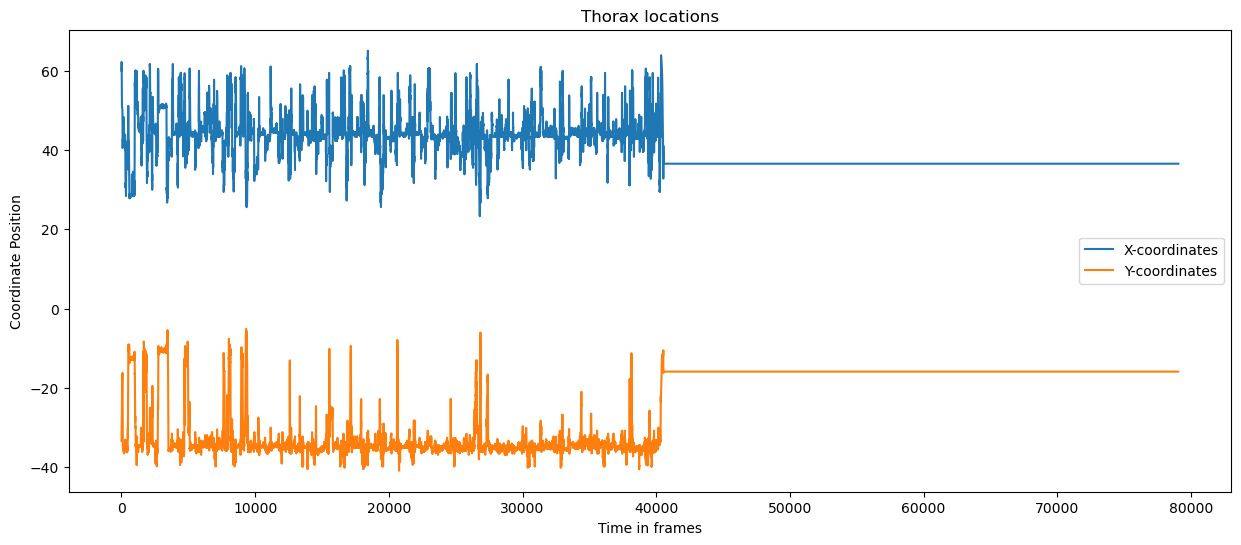

In [67]:
fig, ax = plt.subplots()

plt.plot(thorax_loc[:,0],label='X-coordinates')
# Converting to negative so that we can see both x and y track
plt.plot(-1*thorax_loc[:,1], label='Y-coordinates')

plt.legend(loc="center right")
plt.title('Thorax locations')
plt.xlabel("Time in frames")
plt.ylabel("Coordinate Position")

Text(0, 0.5, 'Y-Coordinates')

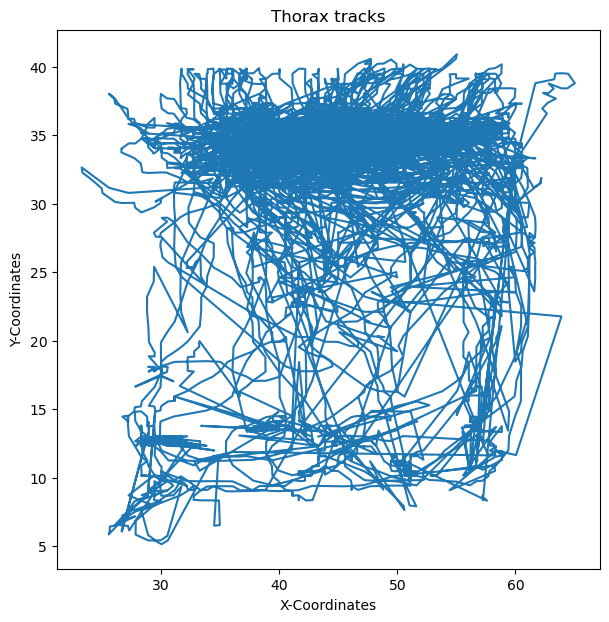

In [68]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0],thorax_loc[:,1])


plt.title('Thorax tracks')
plt.xlabel("X-Coordinates")
plt.ylabel("Y-Coordinates")


## Creating an individual column for each pose tracking

In [69]:
# VIDEO_TO_FRAME_AND_SUBJECT_DF["agent"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: list(set(x["all_subjects"]) - set(x["subject"]))[0], axis=1)

VIDEO_TO_FRAME_AND_SUBJECT_DF["agent"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: list((set(x["all_subjects"]) - set([x["subject"]])))[0], axis=1)

In [70]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,cohort,session_dir,tone_frames,port_entry_frames,video_name,session_path,recording,subject,all_subjects,first_timestamp,...,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_bottom_left,box_bottom_right,reward_port,box_top_right,agent
0,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,"[1.1, 1.2]",3478533,...,212.446672,0.138858,0.090580,"{'1.1': [[[57.86163469 31.55456236], [59.99533...","[29.623370221193532, 10.85380707317621]","[30.23007505102494, 34.598706975722735]","[59.970152006661486, 34.80800954687534]","[45.28271137676262, 36.359497739654486]","[58.88329326555699, 10.55290944942185]",1.2
1,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,"[1.1, 1.2]",3478533,...,212.446672,0.138858,0.090580,"{'1.1': [[[57.86163469 31.55456236], [59.99533...","[29.623370221193532, 10.85380707317621]","[30.23007505102494, 34.598706975722735]","[59.970152006661486, 34.80800954687534]","[45.28271137676262, 36.359497739654486]","[58.88329326555699, 10.55290944942185]",1.1
2,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,"[1.1, 1.4]",835680,...,214.308233,0.137652,0.092440,"{'1.1': [[[46.8389676 35.87977984], [44.64656...","[28.94954695212123, 11.559275766924861]","[29.794023445649177, 35.275466614423074]","[59.48640645086775, 35.36893406869099]","[44.59493426883317, 37.290222508536225]","[58.25716394690266, 11.0851249161892]",1.4
3,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.4,"[1.1, 1.4]",835680,...,214.308233,0.137652,0.092440,"{'1.1': [[[46.8389676 35.87977984], [44.64656...","[28.94954695212123, 11.559275766924861]","[29.794023445649177, 35.275466614423074]","[59.48640645086775, 35.36893406869099]","[44.59493426883317, 37.290222508536225]","[58.25716394690266, 11.0851249161892]",1.1
4,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.1,"[1.1, 1.2]",2502881,...,214.647754,0.137434,0.090034,"{'1.1': [[[41.77548574 33.14423169], [41.20698...","[28.726306016601946, 10.842459364362139]","[30.091010784999508, 34.98257973535351]","[59.534675462363765, 34.36103254330584]","[44.54098011165848, 36.54165425213083]","[58.282641339237685, 10.501152914297204]",1.2
5,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.2,"[1.1, 1.2]",2502881,...,214.647754,0.137434,0.090034,"{'1.1': [[[41.77548574 33.14423169], [41.20698...","[28.726306016601946, 10.842459364362139]","[30.091010784999508, 34.98257973535351]","[59.534675462363765, 34.36103254330584]","[44.54098011165848, 36.54165425213083]","[

In [71]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: x["rescaled_locations"][x["subject"]] , axis=1)

In [72]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["agent_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: x["rescaled_locations"][x["agent"]] , axis=1)

## Removing unnecessary columns

In [73]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(["sleap_glob", "subject_to_index", "subject_to_tracks", "corner_parts", "corner_to_coordinate", "bottom_width", "top_width", "right_height", "left_height", "average_height", "average_width", "width_ratio", "height_ratio", 'locations', 'current_subject', 'track_names', 'sleap_path', 'corner_path', 'all_sleap_data', 'rescaled_locations'], errors="ignore", axis=1)

In [74]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.columns

Index(['cohort', 'session_dir', 'tone_frames', 'port_entry_frames',
       'video_name', 'session_path', 'recording', 'subject', 'all_subjects',
       'first_timestamp', 'raw_timestamps', 'video_timestamps',
       'tone_timestamps', 'port_entry_timestamps', 'lfp_timestamps',
       'mpfc_lfp_trace', 'vhpc_lfp_trace', 'bla_lfp_trace', 'lh_lfp_trace',
       'md_lfp_trace', 'box_top_left', 'box_bottom_left', 'box_bottom_right',
       'reward_port', 'box_top_right', 'agent', 'subject_locations',
       'agent_locations'],
      dtype='object')

In [75]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,cohort,session_dir,tone_frames,port_entry_frames,video_name,session_path,recording,subject,all_subjects,first_timestamp,...,lh_lfp_trace,md_lfp_trace,box_top_left,box_bottom_left,box_bottom_right,reward_port,box_top_right,agent,subject_locations,agent_locations
0,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,"[1.1, 1.2]",3478533,...,"[0.0040029064, -0.11808574, -0.052037787, 0.17...","[0.103898674, -0.011922799, 0.020439083, 0.136...","[29.623370221193532, 10.85380707317621]","[30.23007505102494, 34.598706975722735]","[59.970152006661486, 34.80800954687534]","[45.28271137676262, 36.359497739654486]","[58.88329326555699, 10.55290944942185]",1.2,"[[[57.86163468579171, 31.554562356382696], [59...","[[[40.039741738777444, 9.47029992556593], [42...."
1,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,"[1.1, 1.2]",3478533,...,"[1.0252244, 1.567814, 1.8645895, 1.6457549, 1....","[0.8103085, 0.9092951, 0.8448387, 0.6675837, 0...","[29.623370221193532, 10.85380707317621]","[30.23007505102494, 34.598706975722735]","[59.970152006661486, 34.80800954687534]","[45.28271137676262, 36.359497739654486]","[58.88329326555699, 10.55290944942185]",1.1,"[[[40.039741738777444, 9.47029992556593], [42....","[[[57.86163468579171, 31.554562356382696], [59..."
2,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,"[1.1, 1.4]",835680,...,"[0.33724487, 0.4972933, 0.52396804, 0.39059433...","[0.0032272236, -0.066158086, -0.07422615, 0.05...","[28.94954695212123, 11.559275766924861]","[29.794023445649177, 35.275466614423074]","[59.48640645086775, 35.36893406869099]","[44.59493426883317, 37.290222508536225]","[58.25716394690266, 11.0851249161892]",1.4,"[[[46.838967596646405, 35.8797798363605], [44....","[[[31.37122566669405, 31.1085619584881], [33.5..."
3,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.4,"[1.1, 1.4]",835680,...,"[-0.8462542, -1.1688362, -1.3489795, -1.064101...","[-0.4082438, -0.6508234, -0.85198706, -0.83423...","[28.94954695212123, 11.559275766924861]","[29.794023445649177, 35.275466614423074]","[59.48640645086775, 35.36893406869099]","[44.59493426883317, 37.290222508536225]","[58.25716394690266, 11.0851249161892]",1.1,"[[[31.37122566669405, 31.1085619584881], [33.5...","[[[46.838967596646405, 35.8797798363605], [44...."
4,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.1,"[1.1, 1.2]",2502881,...,"[-0.1610439, -0.28040585, -0.1496761, 0.113678...","[-0.28975692, -0.2704398, 0.02253665, 0.333220...","[28.726306016601946, 10.842459364362139]","[30.091010784999508, 34.98257973535351]","[59.534675462363765, 34.36103254330584]","[44.54098011165848, 36.54165425213083]","[58.282641339237685, 10.501152914297204]",1.2,"[[[41.77548574260138, 33.14423168550605], [41....","

# Adding the start/stop frame information

In [76]:
START_STOP_FRAME_DF.head()

,file_path,start_frame,stop_frame,tracked_subject,in_video_subjects,notes
1,/scratch/back_up/reward_competition_extention/...,1.0,25000.0,6.3,6.1_6.3,NaN
2,/scratch/back_up/reward_competition_extention/...,27500.0,73600.0,6.1_6.3,6.1_6.3,NaN
3,/scratch/back_up/reward_competition_extention/...,51500.0,76454.0,6.3,6.1_6.3,NaN
4,/scratch/back_up/reward_competition_extention/...,1.0,48500.0,6.1_6.3,6.1_6.3,NaN
5,/scratch/back_up/reward_competition_extention/...,41000.0,79050.0,1.1,1.1_1.2,NaN


- Getting relevant metadata for each video

In [77]:
# Getting all the rows that have two subjects
START_STOP_FRAME_DF["tracked_subject"] = START_STOP_FRAME_DF["tracked_subject"].apply(lambda x: str(x).split("_"))
START_STOP_FRAME_DF = START_STOP_FRAME_DF[START_STOP_FRAME_DF["tracked_subject"].apply(lambda x: len(x) == 2)]

In [78]:
# Getting the sleap filename from file path
START_STOP_FRAME_DF["sleap_filename"] = START_STOP_FRAME_DF["file_path"].apply(lambda x: os.path.basename(x))

In [79]:
# Getting the sleap fileroot from the sleap filename
START_STOP_FRAME_DF["sleap_fileroot"] = START_STOP_FRAME_DF["sleap_filename"].apply(lambda x: ".".join(x.split(".")[0:2]))

In [80]:
# Combining the start and stop frame columns into a tuple
START_STOP_FRAME_DF["start_stop_frame"] = START_STOP_FRAME_DF.apply(lambda x: (int(x["start_frame"]), int(x["stop_frame"])), axis=1)
START_STOP_FRAME_DF = START_STOP_FRAME_DF.drop(columns=["start_frame", "stop_frame"], errors="ignore")

- Merging the dataframes based on shared SLEAP file basename

In [81]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.merge(left=VIDEO_TO_FRAME_AND_SUBJECT_DF, right=START_STOP_FRAME_DF, left_on="video_name", right_on="sleap_fileroot", how="left")

- Converting the start/stop frames into timestamps

In [82]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["start_stop_timestamps"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: (x["video_timestamps"][x["start_stop_frame"][0]], x["video_timestamps"][x["start_stop_frame"][1]]), axis=1)

## Going from frame information to ephys

In [83]:
for trace_col in [col for col in VIDEO_TO_FRAME_AND_SUBJECT_DF.columns if "lfp_trace" in col]:
    print(trace_col)
    brain_region = trace_col.split("_")[0]
    VIDEO_TO_FRAME_AND_SUBJECT_DF["filtered_{}_trace".format(brain_region)] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(x["start_stop_timestamps"][0], x["start_stop_timestamps"][1], x["lfp_timestamps"], x[trace_col])[1], axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF["filtered_lfp_timestamps"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(x["start_stop_timestamps"][0], x["start_stop_timestamps"][1], x["lfp_timestamps"], x["lfp_timestamps"])[0], axis=1)

mpfc_lfp_trace
vhpc_lfp_trace
bla_lfp_trace
lh_lfp_trace
md_lfp_trace


In [84]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(columns=[col for col in VIDEO_TO_FRAME_AND_SUBJECT_DF.columns if "lfp_trace" in col], errors="ignore")
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(columns=["lfp_timestamps"], errors="ignore")

In [85]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,cohort,session_dir,tone_frames,port_entry_frames,video_name,session_path,recording,subject,all_subjects,first_timestamp,...,sleap_filename,sleap_fileroot,start_stop_frame,start_stop_timestamps,filtered_mpfc_trace,filtered_vhpc_trace,filtered_bla_trace,filtered_lh_trace,filtered_md_trace,filtered_lfp_timestamps
0,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,"[1.1, 1.2]",3478533,...,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,"(1, 39500)","(1384, 39574889)","[0.015505511, 0.62215865, 1.1086441, 1.3373504...","[-1.3505517, -0.8568693, -0.33960325, 0.141501...","[-1.7142574, -1.1298128, -0.101937994, 0.48760...","[-2.3216858, -1.907385, -1.5471234, -1.4290377...","[-2.3028033, -2.0405018, -1.7475417, -1.429032...","[1400, 1420, 1440, 1460, 1480, 1500, 1520, 154..."
1,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,"[1.1, 1.2]",3478533,...,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,"(1, 39500)","(1384, 39574889)","[0.6574679, 0.11276958, -0.3659692, -0.3723524...","[0.7847764, 0.6408233, 0.48410022, 0.30299798,...","[0.5454766, 0.5454766, 0.5228427, 0.518316, 0....","[0.19785033, -0.25780496, -0.2787891, 0.119909...","[-0.62384546, -0.897785, -1.1164762, -0.982959...","[1400, 1420, 1440, 1460, 1480, 1500, 1520, 154..."
2,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,"[1.1, 1.4]",835680,...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,"(1, 32316)","(1384, 32376683)","[0.31349525, 0.40279388, 0.41229373, 0.3039953...","[0.35449925, 0.8595823, 1.0148718, 0.86899376,...","[0.6661627, 0.8376996, 0.9243008, 1.0025749, 0...","[0.6916378, 0.96981716, 0.9088464, 0.7583246, ...","[0.3162679, 0.49376523, 0.4066302, 0.13715701,...","[1400, 1420, 1440, 1460, 1480, 1500, 1520, 154..."
3,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.4,"[1.1, 1.4]",835680,...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,"(1, 32316)","(1384, 32376683)","[1.8754106, 0.06580388, -1.1351169, 0.23031357...","[2.2451546, 1.6649991, 1.3395461, 1.8442342, 1...","[2.131642, 1.495331, 1.0403687, 1.6066855, 1.8...","[0.6786791, -0.12149195, -0.31839266, 0.494346...","[0.7159058, -0.05324919, -0.6389903, 0.0, 0.44...","[1400, 1420, 1440, 1460, 1480, 1500, 1520, 154..."
4,2,20230620_114347_standard_comp_to_omission_D4_s...,"[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183], [197, 218], [3...",20230620_114347_standard_comp_to_omission_D4_s...,/scratch/back_up/reward_competition_extention/...,20230620_114347_standard_comp_to_omission_D4_s...,1.1,"[1.1, 1.2]",2502881,...,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,"(2027, 32239)","(2021982, 32290759)","[0.96733546, 0.90309834, 0.82374656, 0.7462842...","[-0.43027794, -0.39102963, -0.3735859

In [86]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_timestamps"].iloc[0]

array([      -2,     1384,     1500, ..., 79697199, 79698585, 79699971],
      dtype=int32)

In [87]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_timestamps"].apply(lambda x: x.shape)

0    (79051,)
1    (79051,)
2    (68495,)
3    (68495,)
4    (68288,)
5    (68288,)
6    (69768,)
Name: video_timestamps, dtype: object

In [88]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_locations"].apply(lambda x: x.shape)

0    (79051, 6, 2)
1    (79051, 6, 2)
2    (68495, 6, 2)
3    (68495, 6, 2)
4    (68288, 6, 2)
5    (68288, 6, 2)
6    (69768, 6, 2)
Name: subject_locations, dtype: object

In [89]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["recording"].iloc[5]

'20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged'

In [90]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["filtered_subject_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(x["start_stop_timestamps"][0], x["start_stop_timestamps"][1], x["video_timestamps"], x["subject_locations"])[1], axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF["filtered_agent_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(x["start_stop_timestamps"][0], x["start_stop_timestamps"][1], x["video_timestamps"], x["agent_locations"])[1], axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF["filtered_video_timestamps"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(x["start_stop_timestamps"][0], x["start_stop_timestamps"][1], x["video_timestamps"], x["video_timestamps"])[0], axis=1)

In [91]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(columns=["video_timestamps", "subject_locations", "agent_locations"], errors="ignore")

In [92]:
# Sorting column names for easier reading
sorted_columns = sorted(VIDEO_TO_FRAME_AND_SUBJECT_DF.columns, key=lambda x: x.split("_")[-1])

In [93]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF[sorted_columns].copy()

In [94]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.columns

Index(['agent', 'cohort', 'session_dir', 'sleap_filename', 'sleap_fileroot',
       'start_stop_frame', 'tone_frames', 'port_entry_frames', 'box_top_left',
       'box_bottom_left', 'filtered_subject_locations',
       'filtered_agent_locations', 'video_name', 'notes', 'session_path',
       'file_path', 'reward_port', 'recording', 'box_bottom_right',
       'box_top_right', 'subject', 'tracked_subject', 'all_subjects',
       'in_video_subjects', 'first_timestamp', 'raw_timestamps',
       'tone_timestamps', 'port_entry_timestamps', 'start_stop_timestamps',
       'filtered_lfp_timestamps', 'filtered_video_timestamps',
       'filtered_mpfc_trace', 'filtered_vhpc_trace', 'filtered_bla_trace',
       'filtered_lh_trace', 'filtered_md_trace'],
      dtype='object')

In [95]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.to_pickle(os.path.join(OUTPUT_DIR, FULL_LFP_TRACES_PKL))

In [97]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,agent,cohort,session_dir,sleap_filename,sleap_fileroot,start_stop_frame,tone_frames,port_entry_frames,box_top_left,box_bottom_left,...,tone_timestamps,port_entry_timestamps,start_stop_timestamps,filtered_lfp_timestamps,filtered_video_timestamps,filtered_mpfc_trace,filtered_vhpc_trace,filtered_bla_trace,filtered_lh_trace,filtered_md_trace
0,1.2,2,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,"(1, 39500)","[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...","[29.623370221193532, 10.85380707317621]","[30.23007505102494, 34.598706975722735]",...,"[[1030879, 1230878], [3430878, 3630878], [5730...","[[102478, 104881], [110481, 147879], [193083, ...","(1384, 39574889)","[1400, 1420, 1440, 1460, 1480, 1500, 1520, 154...","[1384, 1500, 2770, 4156, 5542, 5542, 6927, 831...","[0.015505511, 0.62215865, 1.1086441, 1.3373504...","[-1.3505517, -0.8568693, -0.33960325, 0.141501...","[-1.7142574, -1.1298128, -0.101937994, 0.48760...","[-2.3216858, -1.907385, -1.5471234, -1.4290377...","[-2.3028033, -2.0405018, -1.7475417, -1.429032..."
1,1.1,2,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,"(1, 39500)","[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...","[29.623370221193532, 10.85380707317621]","[30.23007505102494, 34.598706975722735]",...,"[[1030879, 1230878], [3430878, 3630878], [5730...","[[102478, 104881], [110481, 147879], [193083, ...","(1384, 39574889)","[1400, 1420, 1440, 1460, 1480, 1500, 1520, 154...","[1384, 1500, 2770, 4156, 5542, 5542, 6927, 831...","[0.6574679, 0.11276958, -0.3659692, -0.3723524...","[0.7847764, 0.6408233, 0.48410022, 0.30299798,...","[0.5454766, 0.5454766, 0.5228427, 0.518316, 0....","[0.19785033, -0.25780496, -0.2787891, 0.119909...","[-0.62384546, -0.897785, -1.1164762, -0.982959..."
2,1.4,2,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,"(1, 32316)","[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...","[28.94954695212123, 11.559275766924861]","[29.794023445649177, 35.275466614423074]",...,"[[1099250, 1299250], [3499256, 3699252], [5799...","[[788852, 836852], [838652, 840050], [840652, ...","(1384, 32376683)","[1400, 1420, 1440, 1460, 1480, 1500, 1520, 154...","[1384, 2770, 2770, 4155, 5541, 6927, 6927, 831...","[0.31349525, 0.40279388, 0.41229373, 0.3039953...","[0.35449925, 0.8595823, 1.0148718, 0.86899376,...","[0.6661627, 0.8376996, 0.9243008, 1.0025749, 0...","[0.6916378, 0.96981716, 0.9088464, 0.7583246, ...","[0.3162679, 0.49376523, 0.4066302, 0.13715701,..."
3,1.1,2,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,"(1, 32316)","[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...","[28.94954695212123, 11.559275766924861]","[29.794023445649177, 35.275466614423074]",...,"[[1099250, 1299250], [3499256, 3699252], [5799...","[[788852, 836852], [838652, 840050], [840652, ...","(1384, 32376683)","[1400, 1420, 1440, 1460, 1480, 1500, 1520, 154...","[1384, 2770, 2770, 4155, 5541, 6927, 6927, 831...","[1.8754106, 0.06580388, -1.1351169, 0.23031357...","[2.2451546, 1.6649991, 1.3395461, 1.8442342, 1...","[2.131642, 1.495331, 1.0403687, 1.6066855, 1.8...","[0.6786791, -0.12149195, -0.31839266, 0.494346...","[0.7159058, -0.05324919, -0.6389903, 0.0, 0.44..."
4,1.2,2,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,"(2027, 32239)","[[1058, 1265], [3460, 3659], [5756, 5955], [75...","[[6, 29], [32, 40], [168, 183]

In [96]:
raise ValueError()

ValueError: 

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["start_stop_lfp_mask"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: np.logical_and(x["lfp_timestamps"] > x["start_stop_timestamps"][0], x["lfp_timestamps"] < x["start_stop_timestamps"][1]), axis=1)
                                                                                           


In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["start_stop_lfp_mask"].iloc[0]

In [ ]:
for trace_col in [col for col in VIDEO_TO_FRAME_AND_SUBJECT_DF.columns if "lfp_trace" in col]:
    VIDEO_TO_FRAME_AND_SUBJECT_DF["".format(trace_col)] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: x[trace_col][x["start_stop_lfp_mask"]], axis=1)"]:


In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["start_stop_mpfc_lfp_trace"].iloc[0].shape

In [ ]:
1617949/1000

In [ ]:
31159889/20000

- Using the start and stop of each subject to remove all other frames where the subject(s) are not there

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_locations"].iloc[0].shape

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_timestamps"].iloc[0].shape

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.columns

In [ ]:
def find_nearest_timestamp_indices(timestamps, other_timestamps, start_index=0, stop_index=1):
    """
    Converts the start and stop indices of one data stream to timestamps, and then finds the nearest start and stop 
    timestamps in another data stream.

    Parameters:
    - timestamps (list[int or float]): The list of timestamps in the first data stream.
    - other_timestamps (list[int or float]): The list of timestamps in the other data stream.
    - start_index (int, optional): The start index in the first data stream. Defaults to 0.
    - stop_index (int, optional): The stop index in the first data stream. Defaults to 1.

    Returns:
    - tuple: The indices of the nearest start and stop timestamps in the other data stream.
    """
    # Convert start and stop indices to timestamps
    start_timestamp = timestamps[start_index]
    stop_timestamp = timestamps[stop_index]

    # Find nearest start and stop timestamps in other data stream
    nearest_start_index = utilities.helper.find_nearest_index(other_timestamps, start_timestamp)
    nearest_stop_index = utilities.helper.find_nearest_index(other_timestamps, stop_timestamp) 

    return nearest_start_index, nearest_stop_index

In [ ]:
convert_index_to_timestamp(0, 100, VIDEO_TO_FRAME_AND_SUBJECT_DF["video_timestamps"].iloc[0], VIDEO_TO_FRAME_AND_SUBJECT_DF["lfp_timestamps"].iloc[0])

In [ ]:
start_frame = VIDEO_TO_FRAME_AND_SUBJECT_DF['port_entry_frames'].iloc[0][0][-1]

In [ ]:
start_frame

In [ ]:
start_timestamp = VIDEO_TO_FRAME_AND_SUBJECT_DF['video_timestamps'].iloc[0][0]

In [ ]:
start_timestamp

In [ ]:
start_lfp = utilities.helper.find_nearest_index(VIDEO_TO_FRAME_AND_SUBJECT_DF["lfp_timestamps"].iloc[0], start_timestamp)

In [ ]:
start_lfp

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["lfp_timestamps"].iloc[0][start_lfp]

In [ ]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["bla_lfp_trace"].iloc[0].shape